In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import matplotlib.patches as pat
from matplotlib.patches import Wedge
from matplotlib.path import Path
from math import pi,sin,cos,sqrt,asin,acos,tan,atan
from matplotlib.gridspec import GridSpec
from matplotlib import cm

In [2]:
def draw_wedges(axe,radius,ang1,ang2,width=0.1,fc=None,ec="r",alpha = 0.5):
    #draw left wedge:
    ang1 = rotate_antiClockwise(ang1)
    ang2 = rotate_antiClockwise(ang2)
    w = pat.Wedge((0,0),radius,ang1,ang2,width = width,fc=fc,ec = ec,alpha = alpha)
    axe.add_artist(w)

def in_range(val,minv = 0, maxv = 1):
    inrange = False
    if minv <= val <= maxv:
        inrange = True
    return inrange

def percent_arc2angle(arc_start,arc_end,percent_d):
    #return angle in degrees
    if arc_start > arc_end:
        raise ValueError("Arc should be pointing clockwise!")
    elif not in_range(arc_start,0,360)*in_range(arc_end,0,360):
        raise ValueError("Arc coordinates out of range!")
    elif not in_range(percent_d,0,1):
        raise ValueError("Point value should be within range of 0-1")
    else:
        arc_span = arc_end-arc_start
        angle = arc_start+arc_span*percent_d
        return angle
    
def polar2xy(r, theta):
    return np.array([r*np.sin(theta), r*np.cos(theta)])

def adjustXYoffset(xy,x_offset = 0.5,y_offset = 0.5):
    return xy+np.array([x_offset,y_offset])

def draw_arc(axe,p1,p2,r):
    if not in_range(p1)*in_range(p2):
        raise ValueError("Value out of range!")
    else:
        ang1 = 2*pi*(5+p1*170)/360
        ang2 = 2*pi*(355-170*p2)/360
        x1,y1 = np.round(np.array([sin(ang1)*r+0.5,cos(ang1)*r+0.5]).astype(float),3)
        x2,y2 = np.round(np.array([sin(ang2)*r+0.5,cos(ang2)*r+0.5]).astype(float),3)
    x_mid,y_mid = (x1+x2)/2,(y1+y2)/2
    ang = atan((y2-y1)/(x2-x1))
    ang_deg = ang*180/pi
    dist = sqrt((y1-y2)**2+(x1-x2)**2)
    rotation = 180
    if y_mid < 0.5:
        rotation = 0
    w = pat.Arc((x_mid,y_mid),dist,min(0.3,0.3/dist),ang_deg+rotation,0,180,fc=None)
    axe.add_artist(w)
    
def polar2xy(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)])

def rotate_antiClockwise(theta,angle=90):
    return (angle-theta)%360

def ChordArc(start1=0,end1=5,\
             start2=345,end2=350,\
             radius_1=0.45, radius_2 = 0.45,chordwidth=0.5, ax=None, alpha = 0.02, color=(1,0,0)):
    # start, end should be in [0, 360)
    start1=rotate_antiClockwise(start1)
    end1=rotate_antiClockwise(end1)
    start2=rotate_antiClockwise(start2)
    end2=rotate_antiClockwise(end2)
    if start1 > end1:
        start1, end1 = end1, start1
    if start2 > end2:
        start2, end2 = end2, start2
    start1 *= np.pi/180.
    end1 *= np.pi/180.
    start2 *= np.pi/180.
    end2 *= np.pi/180.
    opt1 = 4./3. * np.tan((end1-start1)/ 4.) * radius_1
    opt2 = 4./3. * np.tan((end2-start2)/ 4.) * radius_2
    rchord = max(radius_1,radius_2) * (1-chordwidth)
    verts = [
        polar2xy(radius_1, start1),
        polar2xy(radius_1, start1) + polar2xy(opt1, start1+0.5*np.pi),
        polar2xy(radius_1, end1) + polar2xy(opt1, end1-0.5*np.pi),
        polar2xy(radius_1, end1),
        polar2xy(rchord, end1),
        polar2xy(rchord, start2),
        polar2xy(radius_2, start2),
        polar2xy(radius_2, start2) + polar2xy(opt2, start2+0.5*np.pi),
        polar2xy(radius_2, end2) + polar2xy(opt2, end2-0.5*np.pi),
        polar2xy(radius_2, end2),
        polar2xy(rchord, end2),
        polar2xy(rchord, start1),
        polar2xy(radius_1, start1),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = pat.PathPatch(path, facecolor=color, edgecolor=color, lw=2,alpha = alpha)
        ax.add_patch(patch)

    
def fasta_reader(file):
    out=""
    f = open(file,"r")
    while True:
        line = f.readline().rstrip()
        if line == "":
            break
        if not line.startswith(">"):
            out += line
    return out

In [173]:
msr_info = pd.read_excel("/Users/jz-rolling/Desktop/AutoP/MSR_reference_new.xls")
plate_4 = msr_info[msr_info["MSR_INDEX"]=="MSR4"].copy().reset_index(drop=True)
plate_4_list = []
for i in range(len(plate_4)):
    locus = plate_4.iloc[i]["MSMEG_####"]
    if not pd.isna(locus):
        plate_4_list.append("MSMEG_"+str(int(locus)).zfill(4))
        
msm_gff = pd.read_excel("/Volumes/Sam/info/msm_gff.xls")
mtb_gff = pd.read_excel("/Volumes/Sam/info/mtb_gff.xlsx")
mtb_genome_size = len(fasta_reader("/Users/jz-rolling/Downloads/Mycobacterium_tuberculosis_H37Rv_genome_v3.fasta"))
msm_genome_size = len(fasta_reader("/Users/jz-rolling/Downloads/Mycobacterium_smegmatis_MC2-155_genome_v3.fasta"))
conserved_list = {}
msm_loclist = {}
mtb_loclist = {}
for i in range(len(msm_gff)):
    msm_locus = msm_gff.iloc[i]["Locus"]
    start = msm_gff.iloc[i]["Start"]
    end = msm_gff.iloc[i]["Stop"]
    msm_loclist[msm_locus] = (start,end)
    if not pd.isna(msm_gff.iloc[i]['Orthologues M. tuberculosis']):
        msm_locus = msm_gff.iloc[i]["Locus"]
        mtb_locus = msm_gff.iloc[i]['Orthologues M. tuberculosis']
        conserved_list[msm_locus] = mtb_locus

for j in range(len(mtb_gff)):
    mtb_locus = mtb_gff.iloc[j]["Locus"]
    start = mtb_gff.iloc[j]["Start"]
    end = mtb_gff.iloc[j]["Stop"]
    mtb_loclist[mtb_locus] = (start,end)

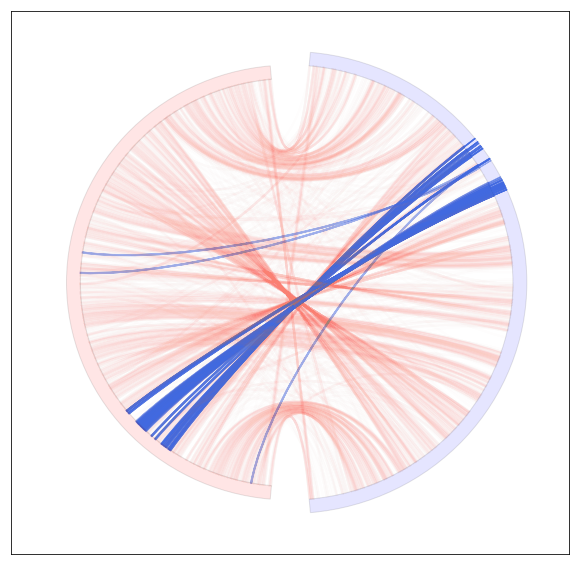

In [203]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#left_half:msm_genome
draw_wedges(ax,0.85,175,5,width=0.05,fc="b",ec="black",alpha = 0.1)
#left_half:mtb_genome
draw_wedges(ax,0.8,355,185,width=0.05,fc="r",ec="black",alpha = 0.1)
for gene in plate_4_list:
    if gene in conserved_list:
        s,e = np.array(msm_loclist[gene]).astype(int)/msm_genome_size
        th1,th2 = percent_arc2angle(5,175,s),percent_arc2angle(5,175,e)
        draw_wedges(ax,0.85,th2,th1,width=0.05,fc="royalblue",ec="royalblue",alpha = 0.5)
    
for msm,mtb in conserved_list.items():
    if msm in plate_4_list:
        c = "royalblue"
        a = 0.5
    else:
        c = "salmon"
        a = 0.01
    mtb = mtb.split(",")
    for locus in mtb:
        s1,e1 = np.array(msm_loclist[msm]).astype(int)/msm_genome_size
        s2,e2 = np.array(mtb_loclist[locus]).astype(int)/mtb_genome_size
        msmth1,msmth2 = percent_arc2angle(5,175,s1),percent_arc2angle(5,175,e1)
        mtbth1,mtbth2 = percent_arc2angle(185,355,1-e2),percent_arc2angle(185,355,1-s2)
        ChordArc(msmth1,msmth2,mtbth1,mtbth2,0.8,0.75,ax=ax,alpha=a,color=c)
fig.savefig("/Users/jz-rolling/PycharmProjects/IMyG_2/Manuscript/figures/genome_correlation.png",bbox_inches = "tight",dpi=200)

In [242]:
def standardize_well(row,col):
    return(row+str(col).zfill(2))

def initiate_plate(rows,cols,well_width = 4):
    row_idx = ["A","B","C","D","E","F","G","H"]
    col_idx = [1,2,3,4,5,6,7,8,9,10,11,12]
    ax_dict = {}
    if (rows)>8 or (cols)>12:
        raise ValueError("384 well plate is not currently supported!")
    else:
        print(rows,cols)
        fig = plt.figure(figsize=(cols,rows))
        gs = GridSpec(rows*well_width,cols*well_width)
        for r in range(0,rows):
            for c in range(0,cols):
                well = standardize_well(row_idx[r],col_idx[c])
                ax = fig.add_subplot(gs[r*well_width:r*well_width+well_width,\
                                                   c*well_width:c*well_width+well_width])
                circ = plt.Circle((0.5,0.5),0.5,fill=False)
                ax.add_artist(circ)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                if r == 0:
                    ax.set_title(str(col_idx[c]),fontsize = 12)
                if c == 0:
                    ax.get_yaxis().set_visible(True)
                    ax.tick_params(top=False,bottom=False,left=False,right=False,\
                                   labelleft=False,labelbottom=False)
                    ax.set_ylabel(row_idx[r]+"  ",rotation=0,position = (0,0.4),fontsize=12)
                ax_dict[well] = ax
    return fig,ax_dict

def convert_to_color(normalized_val):
    if normalized_val>1 or normalized_val<0:
        raise ValueError("Value needs to be normalized!")
    else:
        cmap = cm.get_cmap("Blues")
        return cmap(normalized_val*200)

def draw_well(axes,well_id,values):
    if not well_id in axes:
        raise ValueError("Well id not found!")
    else:
        n_wedges = len(values)
        for i in range(len(values)):
            val = values[i]
            ang0,ang1 = (360/n_wedges)*i,(360/n_wedges)*(i+1)
            w = Wedge((0.5,0.5),0.45,ang0,ang1,fc=convert_to_color(val))
            axes[well_id].add_artist(w)

8 12


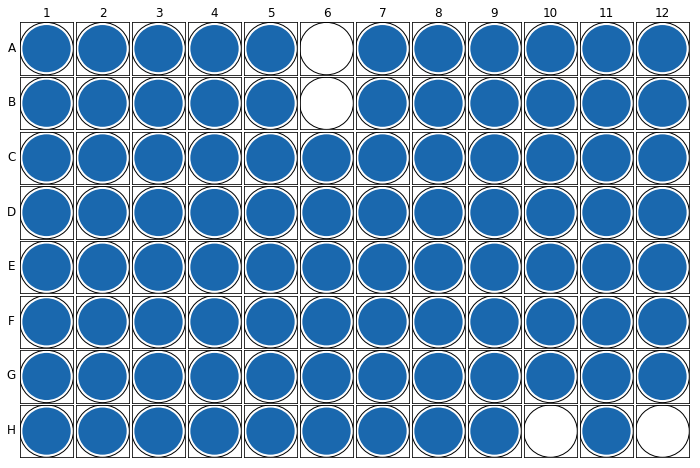

In [245]:
new_plate,wells = initiate_plate(8,12)
for i in range(len(plate_4)):
    well = plate_4.iloc[i]["WELL_NO"]
    locus = plate_4.iloc[i]["MSMEG_####"]
    if not pd.isna(locus):
        locus = "MSMEG_"+str(int(locus)).zfill(4)
        draw_well(wells,well,[1])
    #else:
        #draw_well(wells,well,[0])
new_plate.savefig("/Users/jz-rolling/PycharmProjects/IMyG_2/Manuscript/figures/plate4.png",dpi=200)

In [225]:
cmap = cm.get_cmap("Blues")

In [3]:
mtb_genome_size = len(fasta_reader("/Users/jz-rolling/Downloads/Mycobacterium_tuberculosis_H37Rv_genome_v3.fasta"))
msm_genome_size = len(fasta_reader("/Users/jz-rolling/Downloads/Mycobacterium_smegmatis_MC2-155_genome_v3.fasta"))

In [6]:
msm_genome_size/2

3494104.5